<a href="https://colab.research.google.com/github/Tony363/Chartmetric_Analysis/blob/master/Chartmetric_DataConsolidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
    forcasting followers and listeners over 6 month regression
    model around followers and listeners
    cut off followers lower than 10000
    cut off listeners 100000
    popularity cut off 40
    
    *create new metric(artist score) off of populurity,followers, listeners <- these 3 variables
    homepage and dashboard(UI)
    step 1 <- visual representation of what the platform looks like (basic sustainable platform)
      - barebones UI
      - with plot metrics
    -heursticals timeseries giving it a weights average and aggregate
      (proof of concept first)<-small easy project easy money
    -only use first row of each artist because lack of prevalence
    - diff var / value
    - pair xy regressor    
    """

In [ ]:
!unzip 266_Erick\ Morillo.zip -d path_to_directory

Archive:  266_Erick Morillo.zip
  inflating: path_to_directory/1027_Govinda.csv  
  inflating: path_to_directory/1105_Ike Reilly.csv  
  inflating: path_to_directory/1182_John Travolta.csv  
  inflating: path_to_directory/121_311.csv  
  inflating: path_to_directory/1210_Bounty Killer.csv  
  inflating: path_to_directory/1215_Nappy Roots.csv  
  inflating: path_to_directory/1231_Chaka Demus & Pliers.csv  
  inflating: path_to_directory/1252_Bloodstone.csv  
  inflating: path_to_directory/1267_Patra.csv  
  inflating: path_to_directory/1287_Jason Weaver.csv  
  inflating: path_to_directory/1290_Susan Egan.csv  
  inflating: path_to_directory/1351_My Chemical Romance.csv  
  inflating: path_to_directory/1430_Biffy Clyro.csv  
  inflating: path_to_directory/1476_Tech N9ne.csv  
  inflating: path_to_directory/149_Godsmack.csv  
  inflating: path_to_directory/1607_Michael BublВ.csv  
  inflating: path_to_directory/1649_Young Disciples.csv  
  inflating: path_to_directory/1676_A Tribe Called

In [ ]:
import glob
import pandas as pd

# get data file names
path =r'/content/path_to_directory'
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)

In [ ]:
big_frame.to_csv("Chartmetric_Sample_Data.csv")

model around followers and listeners


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec  4 13:24:30 2020

@author: tony
"""

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler,StandardScaler,RobustScaler
from scipy import stats  
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools

# load in main database of songs and attributes
def load_data():
    df = pd.read_csv("Chartmetric_Sample_Data.csv")
    df.drop('Unnamed: 0',axis=1,inplace=True)
    df.set_index("Chartmetric_ID",inplace=True)
    return df

# set some display options so easier to view all columns at once
def set_view_options(max_cols=50, max_rows=50, max_colwidth=9, dis_width=250):
    pd.options.display.max_columns = max_cols
    pd.options.display.max_rows = max_rows
    pd.set_option('max_colwidth', max_colwidth)
    pd.options.display.width = dis_width
    
def rename_columns(df):
    subidx = [df.columns.get_loc(col) for col in df.columns if "Subject" in col] 
    subjects = df.columns[[subidx]]
    df.rename(columns={df.columns[subidx[idx]]:df.iloc[0,subidx[idx]] for idx,sub in enumerate(subidx)},inplace=True)
    for subject,idx in enumerate(range(0,len(df.columns),7)):
        df.rename(columns={sub:df.columns[subidx[subject]]+" "+sub for idx,sub in enumerate(df.columns[idx+1:idx+7])},inplace=True)
    return df

def get_df_info(df):
    # print memory usage
    print(df.memory_usage(),'\n')
    # take an initial look at our data
    print(df.head(),'\n')

    # take a look at the columns in our data set
    print("The columns are:")
    print(df.columns,'\n')

    # look at data types for each
    info = df.info()
    print(info,'\n')

    # take a look at data types, and it looks like we have a pretty clean data set!
    # However, I think the 0 popularity scores might throw the model(s) off a bit.
    print("Do we have any nulls?")
    print(f"Looks like we have {df.isnull().sum().sum()} nulls\n")
    
    subject_col = []
    statsdf = []
    # look at basic metric mapping
    for idx,col in enumerate(df.columns):
        if idx % 7 != 0:
            try:
                stats = df.agg({col:['min','max','median','mean','skew']})
                subject_col.append(col)
                statsdf.append(stats.transpose())
            except Exception as e:
                # print(e)
                continue
    statsdf = pd.concat(statsdf,axis=0,ignore_index=True)
    statsdf.set_index([pd.Index(subject_col)],inplace=True)
    return statsdf
    # print(df.agg({col:['min','max','median','skew'] for idx,col in enumerate(df.columns) if idx % 7 != 0}))

# calculate and print more stats from the df
def get_stats(df):
    df.reset_index(inplace=True)
    # print stats for various metrics
    print()
    print(f"There are {df.shape[0]} rows")
    print(f"There are {df['Chartmetric_ID'].unique().shape} unique artists")
    print(f"There are {df['popularity value.1'].unique().shape} unique popularity scores")
    print(f"The mean popularity score is {df['popularity value.1'].mean()}")
    print(f"There are {df[df['popularity value.1'] > 55]['popularity value.1'].count()} songs with a popularity score > 55")
    print(f"There are {df[df['popularity value.1'] > 75]['popularity value.1'].count()} songs with a popularity score > 75")
    print(f"Only {(df[df['popularity value.1'] > 80]['popularity value.1'].count() / df.shape[0])*100:.2f} % of artists have a popularity score > 80")
    
def group_time(df):
    timeidx = [df.columns.get_loc(col) for col in df.columns if "timestp" in col] 
    time = df.iloc[:,timeidx]
    df = df.drop(df.columns[timeidx[1:]],axis=1).reset_index().groupby(['followers timestp'])[['Chartmetric_ID','followers value','popularity value.1','listeners value.2','followers_to_listeners_ratio value.3']].first()
    df.fillna(df.mean(),inplace=True)
    df['df followers'] = df['followers value'].pct_change()
    df['df popularity'] = df['popularity value.1'].pct_change()
    df['df listeners'] = df['listeners value.2'].pct_change()
    df['df ratio'] = df['followers_to_listeners_ratio value.3'].pct_change()
    df_std = StandardScaler().fit_transform(df.drop('Chartmetric_ID',axis=1))
    df_norm = MinMaxScaler().fit_transform(df.drop('Chartmetric_ID',axis=1))
    df_std_norm = MinMaxScaler().fit_transform(df_std)
    return df,df_std,df_norm,df_std_norm

def calc_correlations(df, cutoff=0.5):
    corr = df.corr()
    corr_data = corr[corr > cutoff]
    corr_list = df.corr().unstack().sort_values(kind="quicksort",ascending=False)
    return corr_list.drop(corr_list.index[:20]),corr_data

# nice way to truncate the column names to display easier
# can be used with various metrics
def describe_cols(df, L=10):
    '''Limit ENTIRE column width (including header)'''
    # get the max col width
    O = pd.get_option("display.max_colwidth")
    # set max col width to be L
    pd.set_option("display.max_colwidth", L)
    describe = df.rename(columns=lambda x: x[:L - 2] + '...' if len(x) > L else x).describe()
    pd.set_option("display.max_colwidth", O) 
    return describe

# get redundant pairs from DataFrame
def get_redundant_pairs(df):
    '''Get diagonal pairs of correlation matrix and all pairs we'll remove 
    (since pair each is doubled in corr matrix)'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            if df[cols[i]].dtype != 'object' and df[cols[j]].dtype != 'object':
                # print("THIS IS NOT AN OBJECT, YO, so you CAN take a corr of it, smarty!")
                pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    print("The top absolute correlations are:")
    print(au_corr[0:n])
    return au_corr[0:n]
    
# plot a scatter plot
def scatter_plot(df, col_x, col_y):
    plt.scatter(df[col_x], df[col_y], alpha=0.2)
    plt.title(f"{col_x} vs {col_y}")
    plt.xlabel(f"{col_x}")
    plt.ylabel(f"{col_y}")
    plt.show()

def plot_scatter_matrix(df, num_rows):
    scatter_matrix(df[:num_rows], alpha=0.2, figsize=(6, 6), diagonal='kde')
    plt.show()

# plot a heatmap of the correlations between features as well as dependent variable
def plot_heatmap(df):
    # note this looks better in jupyter as well
    plt.figure(figsize = (16,6))
    sns.heatmap(df.corr(), cmap="coolwarm", annot=True, )
    plt.show()
  
# plot a confusion matrix
def plot_confusion_matrix(cm, ax, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    font_size = 24
    p = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=font_size)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=16)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=16)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 1 and j == 1:
            lbl = "(True Positive)"
        elif i == 0 and j == 0:
            lbl = "(True Negative)"
        elif i == 1 and j == 0:
            lbl = "(False Negative)"
        elif i == 0 and j == 1:
            lbl = "(False Positive)"
        ax.text(j, i, "{:0.2f} \n{}".format(cm[i, j], lbl),
                 horizontalalignment="center", size = font_size,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    ax.set_ylabel('True',fontsize=font_size)
    ax.set_xlabel('Predicted',fontsize=font_size)
    
# plot polularity scores distribution
def plot_pop_dist(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.distplot(df['popularity value.1']/100, color='g', label="Popularity").set_title("Distribution of Popularity Scores - Entire Data Set")

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")

    plt.show()

# plot undersampling methodology
def undersample_plot(df):
    # set palette
    sns.set_palette('muted')

    # create initial figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    sns.distplot(df['popularity value.1']/100, color='g', label="Popularity").set_title("Illustration of Undersampling from Data Set")
    
    # create line to shade to the right of
    line = ax.get_lines()[-1]
    x_line, y_line = line.get_data()
    mask = x_line > 0.55
    x_line, y_line = x_line[mask], y_line[mask]
    ax.fill_between(x_line, y1=y_line, alpha=0.5, facecolor='red')

    # get values for and plot first label
    label_x = 0.5
    label_y = 4
    arrow_x = 0.6
    arrow_y = 0.2

    arrow_properties = dict(
        facecolor="black", width=2,
        headwidth=4,connectionstyle='arc3,rad=0')

    plt.annotate(
        "First, sample all songs in this range.\n Sample size is n. Cutoff is 0.5.", xy=(arrow_x, arrow_y),
        xytext=(label_x, label_y),
        bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.5),
        arrowprops=arrow_properties)

    # Get values for and plot second label
    label_x = 0.1
    label_y = 3
    arrow_x = 0.2
    arrow_y = 0.2

    arrow_properties = dict(
        facecolor="black", width=2,
        headwidth=4,connectionstyle='arc3,rad=0')

    plt.annotate(
        "Next, randomly sample \n n songs in this range", xy=(arrow_x, arrow_y),
        xytext=(label_x, label_y),
        bbox=dict(boxstyle='round,pad=0.5', fc='g', alpha=0.5),
        arrowprops=arrow_properties)

    # plot final word box
    plt.annotate(
        "Therefore, end up with a 50/50 \n split of Popular / Not Popular\n songs", xy=(0.6, 2),
        xytext=(0.62, 2),
        bbox=dict(boxstyle='round,pad=0.5', fc='b', alpha=0.5))

    # create x and y axis labels
    plt.xlabel("Popularity")
    plt.ylabel("Density")

    plt.show()

# plot univariate dists for several independent variables
def plot_univ_dists(df, cutoff):
    popularity_cutoff = cutoff
    print('Mean value for followers feature for Popular artists: {}'.format(df[df['popularity value.1'] > popularity_cutoff]['followers value'].mean()))
    print('Mean value for followers feature for Unpopular artists: {}'.format(df[df['popularity value.1'] < popularity_cutoff]['followers value'].mean()))
    print('Mean value for listeners feature for Popular artists: {}'.format(df[df['popularity value.1'] > popularity_cutoff]['listeners value.2'].mean()))
    print('Mean value for listeners feature for Unpopular artists: {}'.format(df[df['popularity value.1'] < popularity_cutoff]['listeners value.2'].mean()))
  
    
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    fig.suptitle('Histograms and Univariate Distributions of Important Features')
    sns.distplot(df[df['popularity value.1'] < popularity_cutoff]['followers value'])
    sns.distplot(df[df['popularity value.1'] > popularity_cutoff]['followers value'])
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.distplot(df[df['popularity value.1'] < popularity_cutoff]['listeners value.2'])
    sns.distplot(df[df['popularity value.1'] > popularity_cutoff]['listeners value.2'])
    plt.show()
    
# initial linear regression function, and plots
def linear_regression_initial(df):
    df = df.copy()
    for col in df.columns:
        X_cols = df.columns.drop(col)
    
        y_col = [col]
    
        X = df[X_cols]
        y = df[y_col]
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
        X_train = sm.add_constant(X_train)
    
        # Instantiate OLS model, fit, predict, get errors
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        fitted_vals = results.predict(X_train)
        stu_resid = results.resid_pearson
        residuals = results.resid
        y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals, \
                               'stu_resid': stu_resid})
    
        # Print the results
        print(results.summary())
    
        # QQ Plot
        fig, ax = plt.subplots(figsize=(8, 5))
        plt.title(f"QQ Plot-{col} Initial Linear Regression")
        fig = sm.qqplot(stu_resid, line='45', fit=True, ax=ax)
        plt.show()
    
        # Residuals Plot
        y_vals.plot(kind='scatter', x='fitted_vals', y='stu_resid')
        plt.title(f"{col} regression")
        plt.show()
        
# Create a basic logistic regression
def basic_logistic_regression(df, cutoff=55, rand=0, sig_only=False):
    df = df.copy()

    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=80, rand=rand))
        X = standardize_X(X)

    X_const = add_constant(X, prepend=True)

    logit_model = Logit(y, X_const).fit()
    
    print(logit_model.summary())

    return logit_model

# various data standardization and X/y split functions for logisitic reression
# based on the columns you want to standardize and return
def return_X_y_logistic(df):
    df = df.copy()

    # define columns to use for each
    X_cols = df.columns

    # use 1's and 0's for logistic
    y_col = df.columns[0]

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

def logistic_regression_with_kfold(df, cutoff=55, rand=0, sig_only=False):
    df = df.copy()
    
    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X(X)

    X = X.values
    y = y.values.ravel()

    classifier = LogisticRegression()

    # before kFold
    y_predict = classifier.fit(X, y).predict(X)
    y_true = y
    accuracy_score(y_true, y_predict)
    print(f"accuracy: {accuracy_score(y_true, y_predict)}")
    print(f"precision: {precision_score(y_true, y_predict)}")
    print(f"recall: {recall_score(y_true, y_predict)}")
    print(f"The coefs are: {classifier.fit(X,y).coef_}")

    # with kfold
    kfold = KFold(len(y))

    accuracies = []
    precisions = []
    recalls = []

    for train_index, test_index in kfold:
        model = LogisticRegression()
        model.fit(X[train_index], y[train_index])

        y_predict = model.predict(X[test_index])
        y_true = y[test_index]

        accuracies.append(accuracy_score(y_true, y_predict))
        precisions.append(precision_score(y_true, y_predict))
        recalls.append(recall_score(y_true, y_predict))

    print(f"accuracy: {np.average(accuracies)}")
    print(f"precision: {np.average(precisions)}")
    print(f"recall: {np.average(recalls)}")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# data clean
df = load_data()  
set_view_options(max_cols=50, max_rows=50, max_colwidth=40, dis_width=250)
duplicated = True in df.columns.duplicated()
print(f"duplicate columns: {duplicated}\n")
df = rename_columns(df)
df.fillna(df.mean(),inplace=True)
grp,grp_std,grp_norm,grp_stdnorm = group_time(df)

duplicate columns: False



/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


Index                                   1224
Chartmetric_ID                          1224
followers value                         1224
popularity value.1                      1224
listeners value.2                       1224
followers_to_listeners_ratio value.3    1224
df followers                            1224
df popularity                           1224
df listeners                            1224
df ratio                                1224
dtype: int64 

                         Chartmetric_ID  followers value  popularity value.1  listeners value.2  followers_to_listeners_ratio value.3  df followers  df popularity  df listeners   df ratio
followers timestp                                                                                                                                                                          
2020-01-01T00:00:00.000Z       Lyrycyst            509.0                 3.0              190.0                                267.89           NaN            

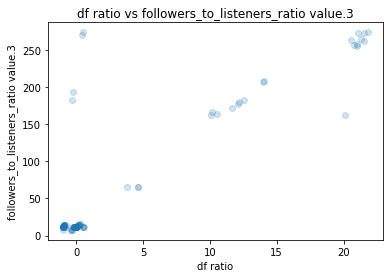

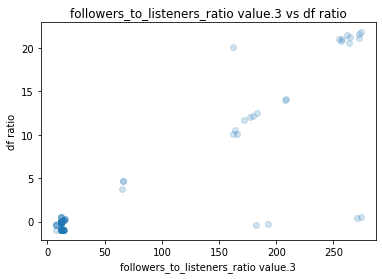

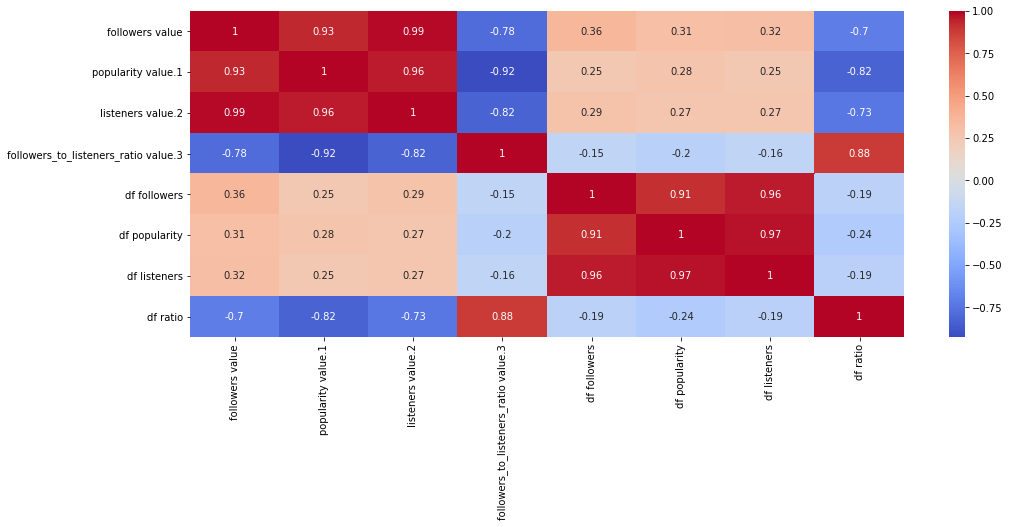

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


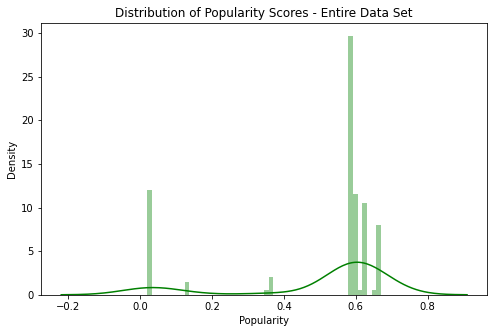

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


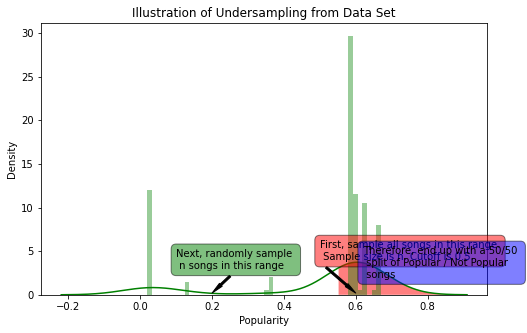

Mean value for followers feature for Popular artists: nan
Mean value for followers feature for Unpopular artists: 163243.60784313726
Mean value for listeners feature for Popular artists: nan
Mean value for listeners feature for Unpopular artists: 1325068.888888889


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

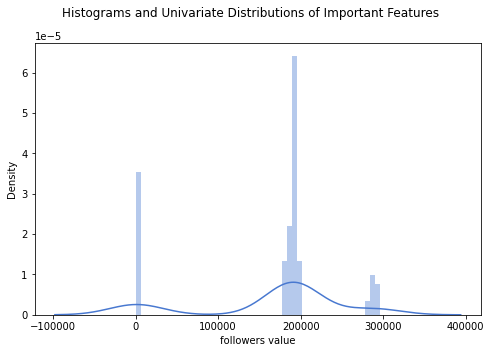

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

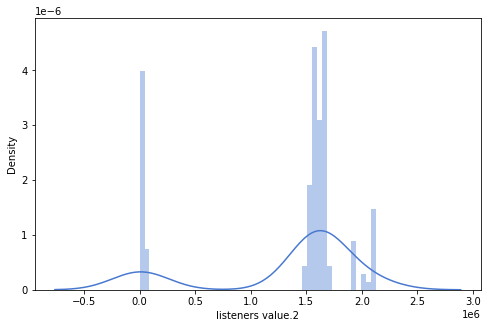

In [3]:
# prelim insights
statsgrp = get_df_info(grp)
# statsgrp_std = get_df_info(grp_std)
# statsgrp_norm = get_df_info(grp_norm)
# statsgrp_stdnorm = get_df_info(grp_stdnorm)
get_stats(grp)
print()
corr_list,corr_data = calc_correlations(grp)
plot_index = corr_list[corr_list > 0.5].index
for plot in plot_index:
  scatter_plot(grp,plot[0],plot[1])
describe = describe_cols(grp,10)
print()
plot_heatmap(grp)
plot_pop_dist(grp)
undersample_plot(grp)
plot_univ_dists(grp, 70)

The top absolute correlations are:
followers value                       listeners value.2                       0.986171
df popularity                         df listeners                            0.974107
popularity value.1                    listeners value.2                       0.961009
df followers                          df listeners                            0.958032
followers value                       popularity value.1                      0.933103
popularity value.1                    followers_to_listeners_ratio value.3    0.924755
df followers                          df popularity                           0.914098
followers_to_listeners_ratio value.3  df ratio                                0.880632
listeners value.2                     followers_to_listeners_ratio value.3    0.824031
popularity value.1                    df ratio                                0.822653
followers value                       followers_to_listeners_ratio value.3    0.784836
listener

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


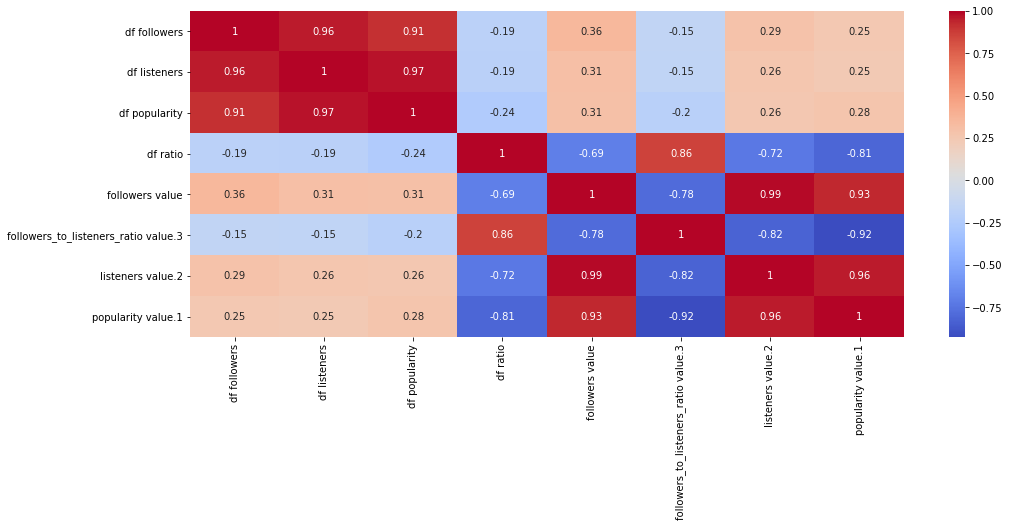

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


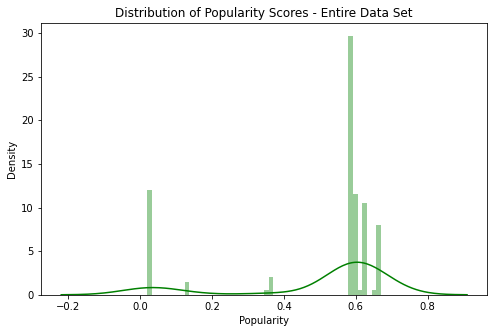

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


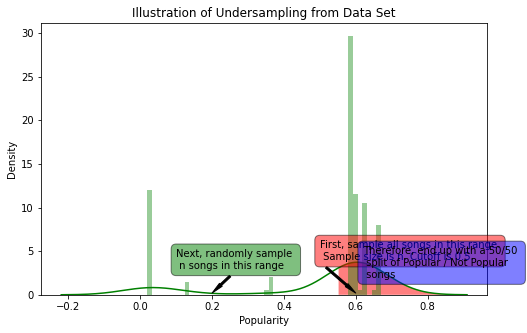

Mean value for followers feature for Popular artists: nan
Mean value for followers feature for Unpopular artists: 163243.60784313726
Mean value for listeners feature for Popular artists: nan
Mean value for listeners feature for Unpopular artists: 1325068.888888889


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

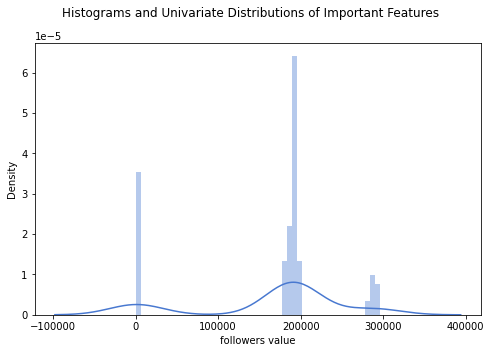

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

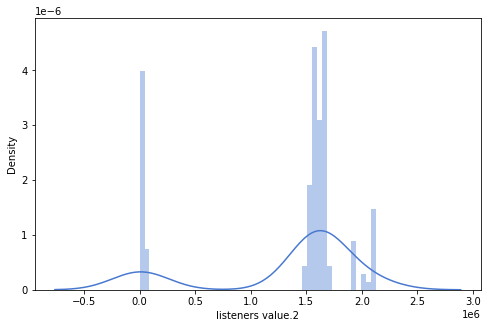

In [4]:
# Data prep
au_corr = get_top_abs_correlations(grp, 50)
train_cols = np.unique((np.asarray([(index[0],index[1]) for index in au_corr.index])).flatten())
dtrain = grp[train_cols]
dtrain.fillna(dtrain.mean(),inplace=True)
plot_heatmap(dtrain)
plot_pop_dist(dtrain)
undersample_plot(dtrain)
plot_univ_dists(dtrain, 70)
    

                            OLS Regression Results                            
Dep. Variable:           df followers   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     296.2
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           1.50e-66
Time:                        12:21:06   Log-Likelihood:                -613.06
No. Observations:                 114   AIC:                             1242.
Df Residuals:                     106   BIC:                             1264.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


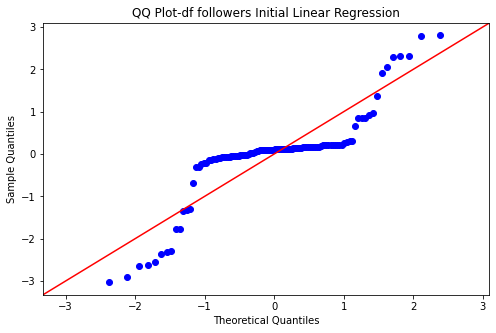

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


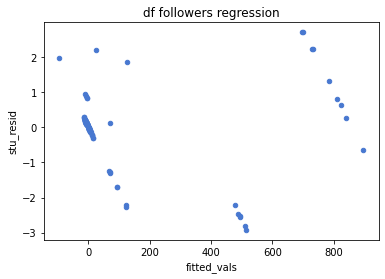

                            OLS Regression Results                            
Dep. Variable:           df listeners   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2135.
Date:                Tue, 08 Dec 2020   Prob (F-statistic):          5.64e-111
Time:                        12:21:07   Log-Likelihood:                -794.55
No. Observations:                 114   AIC:                             1605.
Df Residuals:                     106   BIC:                             1627.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


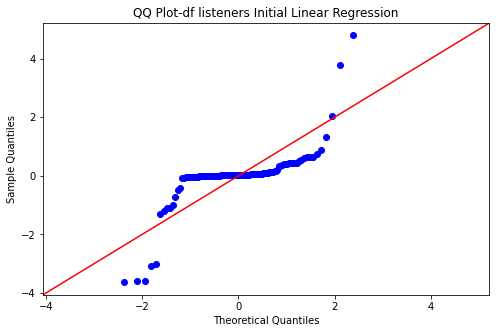

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


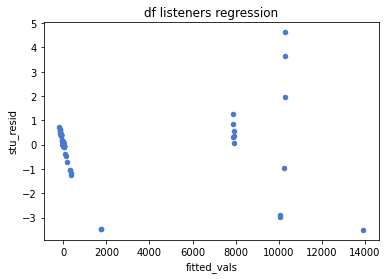

                            OLS Regression Results                            
Dep. Variable:          df popularity   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1575.
Date:                Tue, 08 Dec 2020   Prob (F-statistic):          4.95e-104
Time:                        12:21:07   Log-Likelihood:                -130.67
No. Observations:                 114   AIC:                             277.3
Df Residuals:                     106   BIC:                             299.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


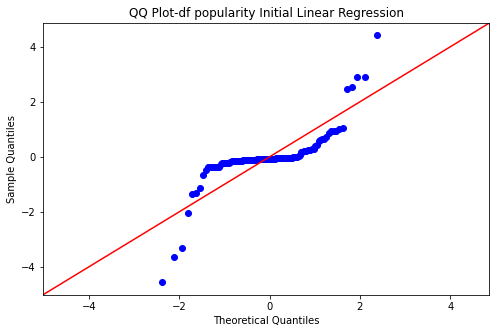

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


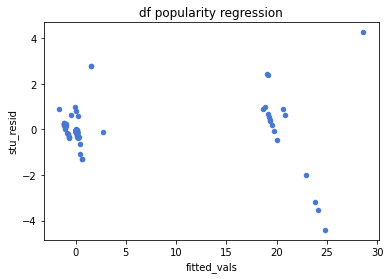

                            OLS Regression Results                            
Dep. Variable:               df ratio   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     29.39
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           3.58e-22
Time:                        12:21:07   Log-Likelihood:                -286.75
No. Observations:                 114   AIC:                             589.5
Df Residuals:                     106   BIC:                             611.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


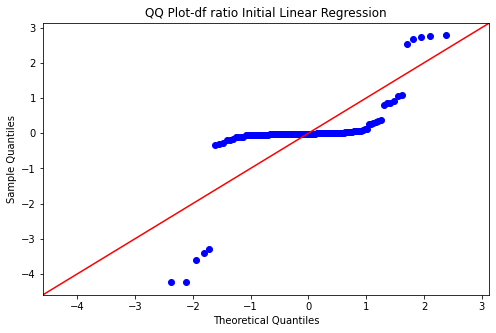

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


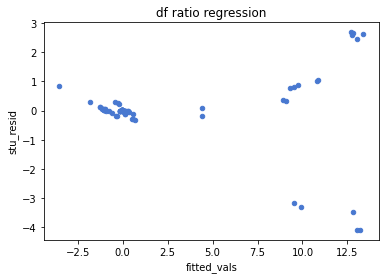

                            OLS Regression Results                            
Dep. Variable:        followers value   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     634.8
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           1.86e-83
Time:                        12:21:08   Log-Likelihood:                -1241.8
No. Observations:                 114   AIC:                             2500.
Df Residuals:                     106   BIC:                             2522.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


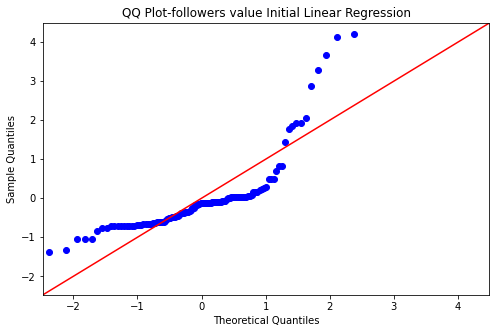

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


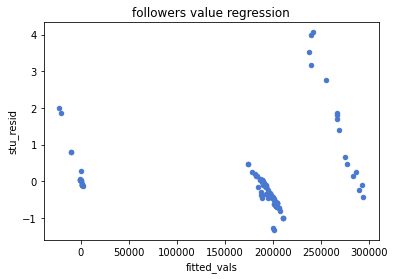

                                     OLS Regression Results                                     
Dep. Variable:     followers_to_listeners_ratio value.3   R-squared:                       0.929
Model:                                              OLS   Adj. R-squared:                  0.925
Method:                                   Least Squares   F-statistic:                     199.1
Date:                                  Tue, 08 Dec 2020   Prob (F-statistic):           5.77e-58
Time:                                          12:21:08   Log-Likelihood:                -513.08
No. Observations:                                   114   AIC:                             1042.
Df Residuals:                                       106   BIC:                             1064.
Df Model:                                             7                                         
Covariance Type:                              nonrobust                                         
                         coef 

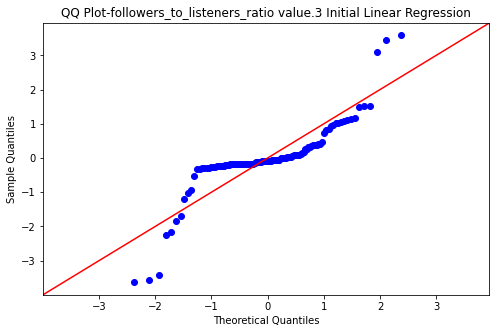

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


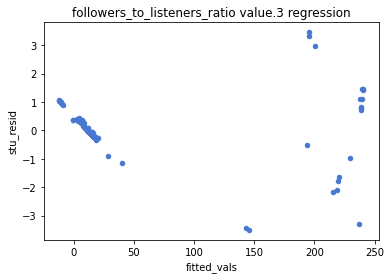

                            OLS Regression Results                            
Dep. Variable:      listeners value.2   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1804.
Date:                Tue, 08 Dec 2020   Prob (F-statistic):          3.91e-107
Time:                        12:21:08   Log-Likelihood:                -1418.3
No. Observations:                 114   AIC:                             2853.
Df Residuals:                     106   BIC:                             2875.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


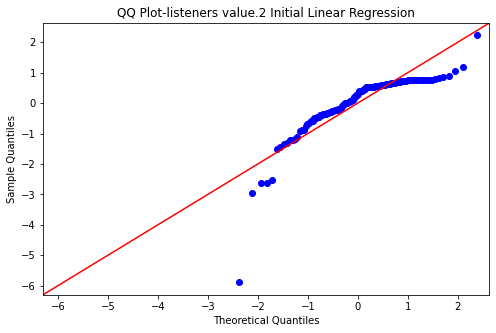

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


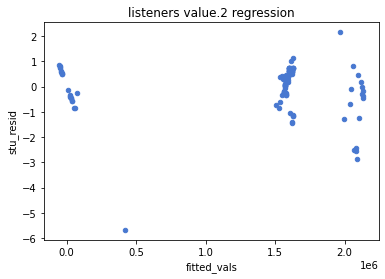

                            OLS Regression Results                            
Dep. Variable:     popularity value.1   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     776.0
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           5.59e-88
Time:                        12:21:09   Log-Likelihood:                -286.75
No. Observations:                 114   AIC:                             589.5
Df Residuals:                     106   BIC:                             611.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


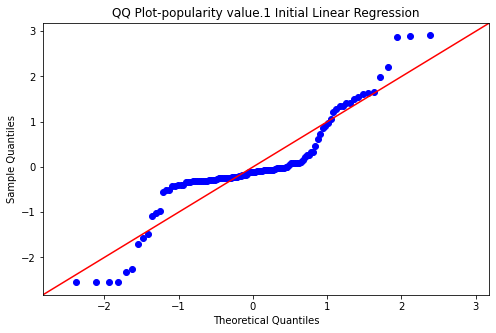

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


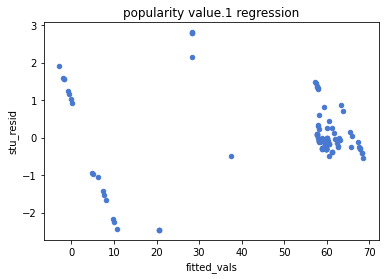

In [5]:
# regression
linear_regression_initial(dtrain)
# basic_logistic_regression(dtrain)

In [6]:
import os 
import psutil

process = psutil.Process(os.getpid())
process.memory_info()


pmem(rss=234532864, vms=1084346368, shared=55631872, text=3883008, lib=0, data=419700736, dirty=0)

In [7]:
import resource
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

229036